In [1]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import List, Dict
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

In [3]:
from dotenv import load_dotenv
load_dotenv() 

gemini_api_key = os.getenv('GEMINI_API_KEY')
gemini_api_key_2 = os.getenv('GEMINI_API_KEY_2')
gemini_api_key_3 = os.getenv('GEMINI_API_KEY_3')
gemini_api_key_4 = os.getenv('GEMINI_API_KEY_4')
gemini_api_key_5 = os.getenv('GEMINI_API_KEY_5')

In [26]:
MODELS = [
    {
        "name": "gemini-1.5-flash-8b",
        "api_key": gemini_api_key,
        "task": f"Inspect the code for vulnerabilities in XML processing and API configurations. Look for XML External Entity (XXE) attacks, insecure API usage, and Security Misconfigurations. Provide the output STRICTLY in the specified structure ONLY, no markdown or other text needed. Required output structure {{\"findings\":[{{\"vulnerability_type\":\"XML External Entity (XXE)\",\"code_snippet\":\"etree.parse(user_input)\",\"recommendation\":\"Disable external entity resolution when processing XML files.\"}},{{\"vulnerability_type\":\"API Misuse\",\"code_snippet\":\"response = requests.post(api_url, data=user_data)\",\"recommendation\":\"Use secure authentication and validate API responses.\"}}]}}. In case no vulnerability found return findings empty"
    },
    {
        "name": "gemini-1.5-flash",
        "api_key": gemini_api_key_2,
        "task": f"Analyze the code for access control vulnerabilities. Look for Insecure Direct Object References (IDOR), Host Header Injection, and Subdomain Takeover risks. Identify instances where access control mechanisms are improperly implemented. Provide the output STRICTLY in the specified structure ONLY, no markdown or other text needed. Required output structure {{\"findings\":[{{\"vulnerability_type\":\"Insecure Direct Object Reference (IDOR)\",\"code_snippet\":\"GET /user/123\",\"recommendation\":\"Implement access controls to verify the requester is authorized to access the resource.\"}},{{\"vulnerability_type\":\"Host Header Injection\",\"code_snippet\":\"url = request.headers['Host'] + '/login'\",\"recommendation\":\"Validate and sanitize the Host header to prevent injection attacks.\"}}]}}. In case no vulnerability found return findings empty"
    },
    {
        "name": "gemini-1.5-flash-8b",
        "api_key": gemini_api_key_3,
        "task": f"Scan the code for vulnerabilities related to file access. Detect instances of Path Traversal, Local File Inclusion (LFI), and Remote File Inclusion (RFI). Focus on functions that handle file paths or include external files. Provide the output STRICTLY in the specified structure ONLY, no markdown or other text needed. Required output structure {{\"findings\":[{{\"vulnerability_type\":\"Path Traversal\",\"code_snippet\":\"open('../../etc/passwd', 'r')\",\"recommendation\":\"Validate file paths and restrict access to specific directories.\"}},{{\"vulnerability_type\":\"Local File Inclusion (LFI)\",\"code_snippet\":\"exec(open(user_input).read())\",\"recommendation\":\"Ensure user input is validated and does not reference sensitive files.\"}}]}}. In case no vulnerability found return findings empty"
    },
    {
        "name": "gemini-1.5-flash",
        "api_key": gemini_api_key_4,
        "task": f"Examine the code for client-side vulnerabilities. Specifically, identify potential Cross-Site Scripting (XSS), Clickjacking, and Content Spoofing issues. Look for improper handling of user-generated content or unsafe rendering practices. Provide the output STRICTLY in the specified structure ONLY, no markdown or other text needed. Required output structure {{\"findings\":[{{\"vulnerability_type\":\"Cross-Site Scripting (XSS)\",\"code_snippet\":\"{{{{ user_input }}}}\",\"recommendation\":\"Escape or sanitize user-generated content before rendering.\"}},{{\"vulnerability_type\":\"Clickjacking\",\"code_snippet\":\"response.headers['X-Frame-Options'] = 'ALLOW'\",\"recommendation\":\"Set 'X-Frame-Options' to 'DENY' or 'SAMEORIGIN' to prevent clickjacking.\"}}]}}. In case no vulnerability found return findings empty"
    },
    {
        "name": "gemini-1.5-flash",
        "api_key": gemini_api_key_5,
        "task": f"Analyze the provided code for vulnerabilities related to user input handling. Specifically, detect cases where user input is directly passed into SQL queries, system commands, or dynamic code execution without validation or sanitization. Focus on identifying potential SQL Injection, Command Injection, and Code Injection vulnerabilities. Provide the output STRICTLY in the specified structure ONLY, no markdown or other text needed. Required output structure {{\"findings\":[{{\"vulnerability_type\":\"SQL Injection\",\"code_snippet\":\"cursor.execute('SELECT * FROM users WHERE id = ' + user_input)\",\"recommendation\":\"Use parameterized queries to prevent SQL injection.\"}},{{\"vulnerability_type\":\"Command Injection\",\"code_snippet\":\"os.system('ping ' + user_input)\",\"recommendation\":\"Validate and sanitize user input before passing it to system commands.\"}}]}}. In case no vulnerability found return findings empty"
    }
]

In [33]:
AGENTS = ["XML and API Agent", "Access Control Agent", "File Access Agent", "Client-side Agent", "User Input Agent"]

In [55]:
class GraphState(TypedDict):
    input_text: str
    results: List[Dict]

In [67]:
import concurrent.futures

def analyze_text(state: GraphState) -> GraphState:
    results = []

    def invoke_model(model_info):
        model = ChatGoogleGenerativeAI(
            model=model_info["name"], google_api_key=model_info["api_key"]
        )      
        response = model.invoke(
            f"Task: {model_info['task']}\nAnalyze the following input:\n{state['input_text']}"
        )
        return {"output": response}

    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_agent = {executor.submit(invoke_model, model_info): model_info for model_info in MODELS}
        for future in concurrent.futures.as_completed(future_to_agent):
            agent_name = future_to_agent[future]
            try:
                result = future.result()
                results.append(result)
            except Exception as exc:
                print(f"{agent_name} generated an exception: {exc}")

    print("\n")
    state["results"] = results
    return state

def merge_results(state: GraphState) -> Dict:
    findings = state.get("results", [])
    final_report = {
        "findings": findings
    }
    return final_report

In [68]:
graph = StateGraph(GraphState)
graph.add_node("analyze", analyze_text)
graph.add_node("merge", merge_results)
graph.set_entry_point("analyze")
graph.add_edge("analyze", "merge")
app = graph.compile()

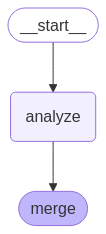

In [30]:
from IPython.display import display, Image
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except:
    pass

In [107]:
import json
import re

def extract_json(target):
    
    json_pattern = r'\{(?:[^{}]|(?:\{[^{}]*\}))*\}'
    json_matches = re.findall(json_pattern, target, re.DOTALL)

    extracted_jsons = []

    for match in json_matches:
        try:
            json_data = json.loads(match)
            if not (isinstance(json_data, dict) and json_data.get('findings') == []):
                extracted_jsons.append(json_data)        
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            print(f"Problematic JSON String: {match}")
    
    return extracted_jsons


In [110]:
import zipfile

def analyze_zip_file(zip_file_path):
    all_findings = {}
    allowed_extensions = {'.py', '.js', '.ts', '.json', '.jsx', '.tsx', '.java', '.xml', '.html', '.css', '.go', '.c', '.cpp'}
    
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if not file_name.endswith('/') and os.path.splitext(file_name)[1].lower() in allowed_extensions:
                with zip_ref.open(file_name) as file:
                    file_content = file.read().decode('utf-8')
                print(file_name)
                try:
                    inputs = {"input_text": file_content}
                    result = app.invoke(inputs)
                    
                    findings = []
                    for output in result['results']:
                        findings.extend(extract_json(output['output'].content))
                    
                    all_findings[file_name] =  findings
                except Exception as e:
                    print(e)
    
    return all_findings

zip_file_path = 'test_files/combination.zip'  
findings = analyze_zip_file(zip_file_path)

combination/some1.py


combination/some2.py


combination/some3.py




In [117]:
findings

{'combination/some1.py': [{'findings': [{'vulnerability_type': 'XML External Entity (XXE)',
     'code_snippet': 'tree = ET.parse(user_input)',
     'recommendation': 'Disable external entity resolution when processing XML files.'}]},
  {'findings': [{'vulnerability_type': 'Cross-Site Scripting (XSS)',
     'code_snippet': 'ET.parse(user_input)',
     'recommendation': 'Validate and sanitize XML input to prevent XML External Entities (XXE) attacks which can lead to XSS.'}]}],
 'combination/some2.py': [{'findings': [{'vulnerability_type': 'API Misuse',
     'code_snippet': 'response = requests.post(api_url, data=user_data)',
     'recommendation': 'Use secure authentication and validate API responses.'}]},
  {'vulnerability_type': 'Insecure Direct Object Reference (IDOR)',
   'code_snippet': '@app.route(\'/user/<int:user_id>\')\ndef get_user(user_id):\n    return f"User ID: {user_id}"',
   'recommendation': 'Implement access controls to verify the requester is authorized to access the r